Summary..
Number of transactions:  19140
Number of products bought:  3627
Number of customers: 3891
Percentage of customers NA:  0.0 %
2020-11-05
The 80% of total revenue is:  555655.05
customer rank
602333.73
            Recency  Frequency  Monetary    Rank
CustomerID                                      
12346.0        3579          2      0.00  3740.5
12747.0        3256         10    658.89   166.0
12748.0        3254        209    533.03   205.0
12749.0        3257          8     62.25  1466.0
12820.0        3257          4     58.20  1518.5
...             ...        ...       ...     ...
18280.0        3531          1     23.70  2409.5
18281.0        3434          1      5.04  3462.5
18282.0        3261          3     36.80  1979.0
18283.0        3257         16     66.75  1385.0
18287.0        3296          3     80.40  1194.0

[3891 rows x 4 columns]
CustomerID
12346.0    3579
12747.0    3256
12748.0    3254
12749.0    3257
12820.0    3257
           ... 
18280.0    3531
18281

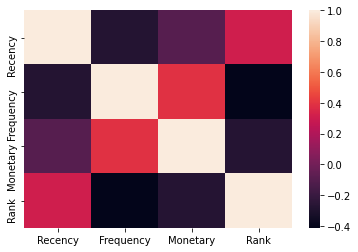

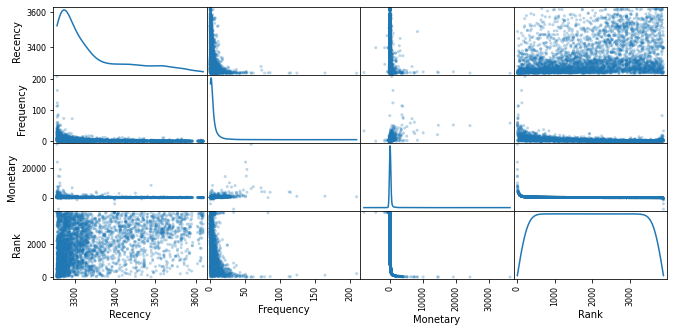

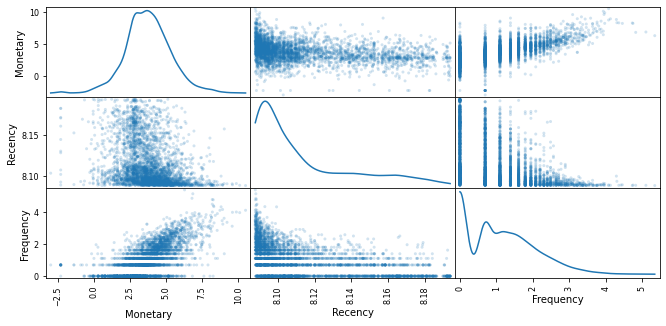

In [ ]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt

!pip install GMM
#modules for predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
##from sklearn.mixture import GMM

from sklearn.metrics import silhouette_samples, silhouette_score

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

#load the dataset
retail_df = pd.read_excel("Online Retail.xlsx")
retail_df.head()

retail_uk = retail_df[retail_df['Country']=='United Kingdom']
#check the shape
retail_uk.shape

#remove rows where customerID are NA
retail_uk.dropna(subset=['CustomerID'],how='all',inplace=True)
retail_uk.shape

#restrict the data to one full year because it's better to use a metric per Months or Years in RFM
retail_uk = retail_uk[retail_uk['InvoiceDate']>= "2010-12-09"]
retail_uk.shape

print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ", retail_uk['InvoiceNo'].nunique())
print("Number of products bought: ",retail_uk['StockCode'].nunique())
print("Number of customers:", retail_uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(retail_uk['CustomerID'].isnull().sum() * 100 / len(retail_df),2),"%" )

#last date available in our dataset
retail_uk['InvoiceDate'].max()

now = dt.date.today()
print(now)

#create a new column called date which contains the date of invoice only
retail_uk['date'] = retail_uk['InvoiceDate'].dt.date

retail_uk.head()
#group by customers and check last date of purshace
recency_df = retail_uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

#calculate recency
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)
recency_df.head()
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)


# drop duplicates
retail_uk_copy = retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

#create column total cost
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']
 
monetary_df = retail_uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()


#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()


#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
#check the head
rfm_df.head()

retail_uk[retail_uk['CustomerID']==12346.0]
#(now - dt.date(2011,1,18)).days == 325

#get the 80% of the revenue
pareto_cutoff = rfm_df['Monetary'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

customers_rank = rfm_df
# Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['Monetary'].rank(ascending=0)
#customers_rank.drop('RevenueRank',axis=1,inplace=True)
customers_rank.head()
print ( 'customer rank')
customers_rank.sort_values('Rank',ascending=True)

#get top 20% of the customers
top_20_cutoff = 3863 *20 /100
top_20_cutoff

#sum the monetary values over the customer with rank <=773
revenueByTop20 = customers_rank[customers_rank['Rank'] <= 772]['Monetary'].sum()
print (revenueByTop20)

#RFM Quartiles
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles


#Creation of RFM segmentation table
#We will create two segmentation classes since, high recency is bad, while high frequency and monetary value is good.
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

print(rfm_df)  
      

 
#create rfm segmentation table
rfm_segmentation = rfm_df

print(rfm_segmentation['Recency'])

rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
print('recency cross')
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))
rfm_segmentation.head()

#Now that we have the score of each customer, we can represent our customer segmentation.
#First, we need to combine the scores (R_Quartile, F_Quartile,M_Quartile) together.

rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

#Best Recency score = 4: most recently purchase. Best Frequency score = 4: most quantity purchase. Best Monetary score = 4: spent the most.
#Let's see who are our Champions (best customers).

rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

#Applying K-means clustering on RFM variables
#Preprocess Data

rfm_data = rfm_df.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore'],axis=1)
rfm_data.head()

#Feature correlations

rfm_data.corr()
sns.heatmap(rfm_data.corr())

scatter_matrix(rfm_data, alpha = 0.3, figsize = (11,5), diagonal = 'kde');

#log transformation
rfm_r_log = np.log(rfm_data['Recency']+0.1) #can't take log(0) and so add a small number
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary']+0.1)
 
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})
 
log_data.head()


# Produce a scatter matrix for each pair of features in the data
scatter_matrix(log_data, alpha = 0.2, figsize = (11,5), diagonal = 'kde');